## Sentiment Analysis - Tweet

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore") 

In [2]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv)
my_df.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [3]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596753 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [4]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596753 entries, 0 to 1596752
Data columns (total 2 columns):
text      1596753 non-null object
target    1596753 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


### Train Test Split

Before we can train any model, we first consider how to split the data. Here I chose to split the data into three chunks: train, development, test.

* **`Train set`**: The sample of data used for learning
* **`Development set (Hold-out cross-validation set)`**: The sample of data used to tune the parameters of a classifier, and provide an unbiased evaluation of a model.
* **`Test set`**: The sample of data used only to assess the performance of a final model.

The ratio I decided to split from my data is 98% of data as the training set, and 1% for the dev set, and the final 1% for the test set. The rationale behind this ratio comes from the size of my whole data set. The dataset has more than 1.5 million entries. In this case, only 1% of the whole data gives me more than 15,000 entries. This is more than enough to evaluate the model and refine the parameters.

Another approach is splitting the data into only train and test set, and run k-fold cross-validation on the training set, so that you can have an unbiased evaluation of a model. But considering the size of the data, I have decided to use the train set only to train a model, and evaluate on the dev set, so that I can quickly test different algorithms and run this process iteratively.

In [5]:
x = my_df.text
y = my_df.target

In [6]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [7]:
print ("Data Train kita terdiri dari {0} entries dengan {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                            (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print ("Data Validation kita teridiri dari {0} entries dengan {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print ("Data Test kita terdiri dari {0} entries dengan {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Data Train kita terdiri dari 1564817 entries dengan 50.00% negative, 50.00% positive
Data Validation kita teridiri dari 15968 entries dengan 50.26% negative, 49.74% positive
Data Test kita terdiri dari 15968 entries dengan 50.18% negative, 49.82% positive


### Model Creation

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [9]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model lebih akurat {0:.2f}% dibandingkan dengan null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model memiliki akurasi yang sama dengan null accuracy")
    else:
        print ("akurasi model {0:.2f}% lebih kecil dibandingkan dengan null accuracy".format((null_accuracy-accuracy)*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(5000,15001,5000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

### TFIDF Vectorizer

TF-IDF is another way to convert textual data to a numeric form and is short for Term Frequency-Inverse Document Frequency. The vector value it yields is the product of these two terms; TF and IDF.

Let's first look at Term Frequency. We have already looked at term frequency above with count vectorizer, but this time, we need one more step to calculate the relative frequency.

Relative term frequency is calculated for each term within each document as below.

${TF(t,d)}$ = $\frac{number of times term(t) appears in document(d)}{total number of terms in document(d)}$

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

#### Akurasi CountVectorizer

In [12]:
%%time
print ("Hasil Unigram CountVectorizer dengan Stopword\n")
feature_result_ug = nfeature_accuracy_checker()

Hasil Unigram CountVectorizer dengan Stopword

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 5000 features
null accuracy: 50.26%
accuracy score: 78.73%
model lebih akurat 28.47% dibandingkan dengan null accuracy
train and test time: 249.76s
--------------------------------------------------------------------------------
Validation result for 10000 features
null accuracy: 50.26%
accuracy score: 79.03%
model lebih akurat 28.76% dibandingkan dengan null accuracy
train and test time: 293.57s
--------------------------------------------------------------------------------
Validation result for 15000 features
null accuracy: 50.26%
accuracy score: 79.20%
model lebih akurat 28.94% dibandingkan dengan null accuracy
train and test time: 228.30s
-------------

#### Akurasi TF-IDF

In [14]:
%%time
print ("Hasil Unigram TF-IDF dengan Stopword\n")
feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)

Hasil Unigram TF-IDF dengan Stopword

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 5000 features
null accuracy: 50.26%
accuracy score: 78.84%
model lebih akurat 28.58% dibandingkan dengan null accuracy
train and test time: 100.75s
--------------------------------------------------------------------------------
Validation result for 10000 features
null accuracy: 50.26%
accuracy score: 79.13%
model lebih akurat 28.86% dibandingkan dengan null accuracy
train and test time: 120.01s
--------------------------------------------------------------------------------
Validation result for 15000 features
null accuracy: 50.26%
accuracy score: 79.26%
model lebih akurat 29.00% dibandingkan dengan null accuracy
train and test time: 120.76s
----------------------

It seems like TFIDF vectorizer is yielding better results when fed to logistic regression. Let's plot the results from count vectorizer together with TFIDF vectorizer.

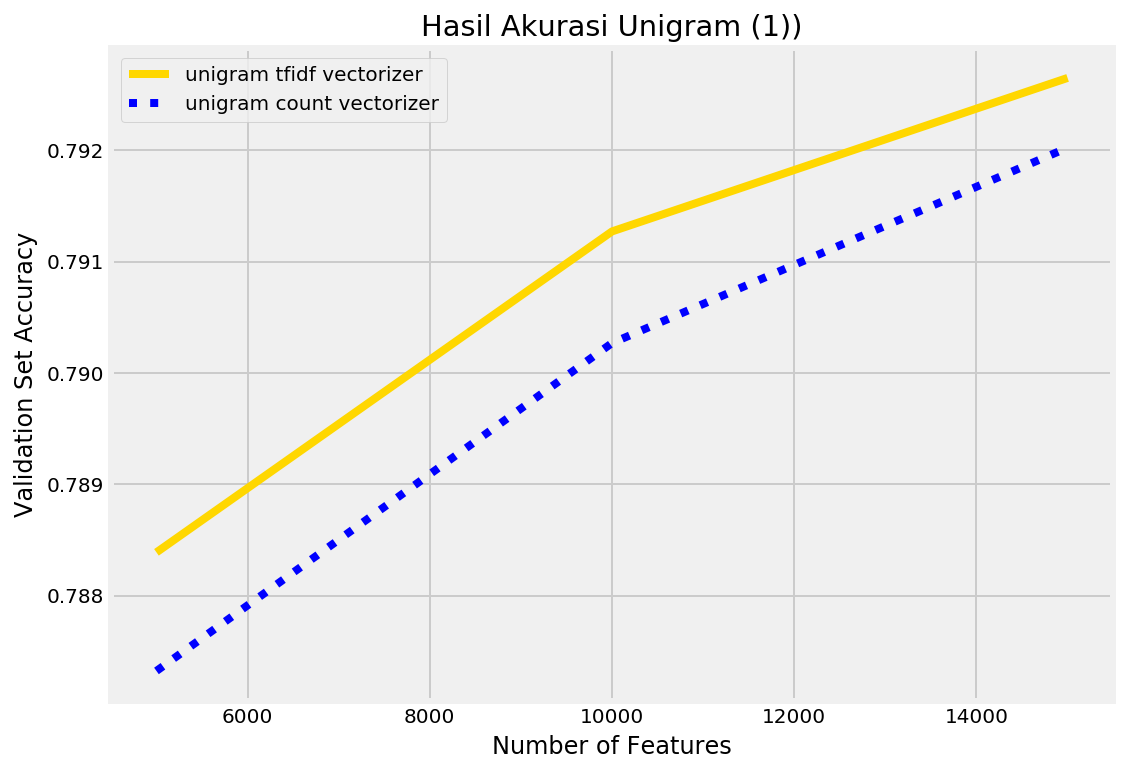

In [16]:
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='blue')
plt.title("Hasil Akurasi Unigram (1))")
plt.xlabel("Number of Features")
plt.ylabel("Validation Set Accuracy")
plt.legend()

From above chart, we can see the model performance both in count vectorizer and TFIDF vectorizer there is a method that support our model more significant (higher accuracy), it is **`TF-IDF Vectorizer`**. And for every case number of features, TF-IDF yields better results than count vectorizer, as per step based on the graph.

### Model Comparison

The best result I can get with logistic regression was by using TFIDF vectorizer of 20,000 features including up to trigram. With this I will first fit various different models and compare their validation results, then I will build an ensemble (voting) classifier with top 3 models (`Logistic Regression`, `LinearSVC`, and `Rigde Classifier`).

In [26]:
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "Ridge Classifier"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    RidgeClassifier(),
    ]
zipped_clf = zip(names,classifiers)

In [27]:
tvec = TfidfVectorizer()
def classifier_comparator(vectorizer=tvec, n_features=20000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Hasil Test Validasi Model {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

In [28]:
unigram_result = classifier_comparator(n_features=20000)

Hasil Test Validasi Model Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
null accuracy: 50.26%
accuracy score: 79.36%
model lebih akurat 29.10% dibandingkan dengan null accuracy
train and test time: 132.30s
--------------------------------------------------------------------------------
Hasil Test Validasi Model Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
null accuracy: 50.26%
accuracy score: 79.14%
model lebih akurat 28.88% dibandingkan dengan null accuracy
train and test time: 910.46s
--------------------------------------------------------------------------------
Hasil Te

In [34]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = RidgeClassifier()
 
eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('rcs', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Linear SVC', 'Ridge Classifier','Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(max_features=20000)),
            ('classifier', clf)
        ])
    print ("Hasil Test Validasi Model {}".format(label))
    print (clf)
        
    clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)

Hasil Test Validasi Model Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
null accuracy: 50.26%
accuracy score: 79.36%
model lebih akurat 29.10% dibandingkan dengan null accuracy
train and test time: 125.30s
--------------------------------------------------------------------------------
Hasil Test Validasi Model Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
null accuracy: 50.26%
accuracy score: 79.17%
model lebih akurat 28.91% dibandingkan dengan null accuracy
train and test time: 900.00s
--------------------------------------------------------------------------------
Hasil Te

It seems like the voting classifier does no better than the simple logistic regression model. So, for final model, we will take and use **`Logistic Regression`** as our best model, because:

1. Model lebih akurat 29.10% dibandingkan dengan null accuracy data
2. Secara umum, akurasinya adalah 79.36%
3. Pemilihan feature terhadap model yang dibangkitkan oleh Regresi Logistik sudah cukup baik dan berhasil memetakan setiap kemunculan term dalam keseluruhan dokumen.

### Future Work

1. For some reason, I think I will try to finetune the logistic regression model. Maybe using Hyperparameter Tuning or Ensemble another method to combine with the original logistic regression model.